In [1]:
import os
import numpy as np
import pandas as pd
import arviz as az
import numpyro
import numpyro.infer.initialization as init
import numpyro.distributions as dist
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, SVI, Predictive, init_to_median
from numpyro.infer.reparam import CircularReparam

from asterion.priors import AsyPrior, HeGlitchPrior, CZGlitchPrior, ZerosPrior
from asterion.gp import GP, SquaredExponential
from asterion import Inference, GlitchModel
# from asterion.inference import CircularReparam
from numpyro.distributions import constraints


In [2]:
data_dir = 'data/prior'
track_name = 'm1.0Y0.26FeH0.0MLT2.1ov0.003556dif1'
track_dir = os.path.join(data_dir, track_name)

track = pd.read_csv(os.path.join(track_dir, f'{track_name}.csv'))
track.head()

,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,initial_fov,star_mass,...,E_0_31,E_0_32,E_0_33,E_0_34,E_0_35,E_0_36,E_0_37,E_0_38,E_0_39,E_0_40
0,profile4,152,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,1.216230e-06,0.000002,0.000006,0.000279,0.000014,0.000003,0.000002,0.000001,8.677974e-07,7.314938e-07
1,profile5,153,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,1.070235e-06,0.000002,0.000004,0.000047,0.000027,0.000004,0.000002,0.000001,8.865659e-07,7.333283e-07
2,profile6,154,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,9.770822e-07,0.000002,0.000003,0.000022,0.000059,0.000005,0.000002,0.000001,9.058076e-07,7.371980e-07
3,profile7,155,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,9.140089e-07,0.000001,0.000003,0.000014,0.000159,0.000006,0.000002,0.000001,9.237271e-07,7.414930e-07
4,profile8,156,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,8.694409e-07,0.000001,0.000002,0.000010,0.000672,0.000007,0.000002,0.000001,9.400169e-07,7.457830e-07


In [3]:
model_number = 708
profile = track.loc[track['model_number']==model_number].iloc[0]

In [4]:
n = np.arange(10, 30)
nu_index = [f'nu_0_{i}' for i in n]
# n = n.astype(float)

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [5]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_sca = profile['delta_nu']
print('delta_nu ~', round(delta_nu_sca, 2), 'muHz')

nu_max ~ 3246.74 muHz
delta_nu ~ 146.6 muHz


Text(0, 0.5, 'nu mod. 140.74 muHz')

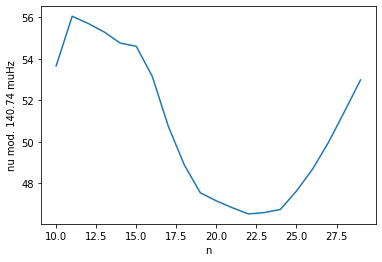

In [6]:
f = 0.96
delta_nu_loc = f*delta_nu_sca
plt.plot(n, nu%delta_nu_loc)
plt.xlabel('n')
plt.ylabel(f'nu mod. {delta_nu_loc:.2f} muHz')

In [7]:
background = AsyPrior(delta_nu=(delta_nu_loc, 0.01*delta_nu_loc))

nu_max = (nu_max_sca, 0.05*nu_max_sca)
he_glitch = HeGlitchPrior(nu_max=nu_max)
cz_glitch = CZGlitchPrior(nu_max=nu_max)

In [8]:
model = GlitchModel(background, he_glitch, cz_glitch)

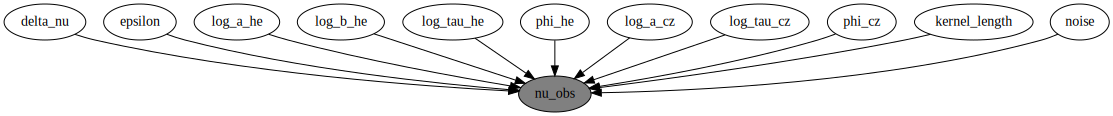

In [9]:
numpyro.render_model(model, model_args=(n,), model_kwargs={'nu': nu})

In [10]:
infer = Inference(model, seed=0)

In [11]:
infer.prior_predictive(model_args=(n,), model_kwargs={'pred': True})

In [12]:
data = infer.get_data()
data

Inference data with groups:
	> prior
	> constant_data

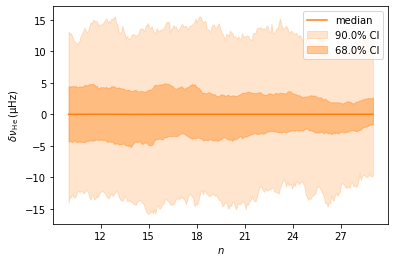

In [13]:
model.plot_glitch(data, group='prior', quantiles=[.05, .16, .84, .95], observed=False);

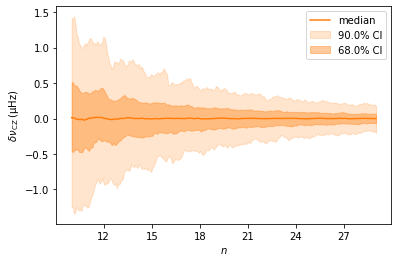

In [14]:
model.plot_glitch(data, kind='CZ', group='prior', quantiles=[.05, .16, .84, .95], observed=False);

In [15]:
handlers = [he_glitch.reparam, cz_glitch.reparam]

infer.sample(num_chains=5, model_args=(n,), model_kwargs={'nu': nu}, handlers=handlers)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:           (metric: 12, n: 20)
Coordinates:
  * n                 (n) int64 10 11 12 13 14 15 16 17 ... 23 24 25 26 27 28 29
  * metric            (metric) <U9 'mean' 'sd' 'hdi_3%' ... '16th' '50th' '84th'
Data variables: (12/21)
    a_cz              (metric) float64 7.359e+05 8.224e+04 ... 8.043e+05
    a_he              (metric) float64 0.004289 0.002229 ... 0.003885 0.005639
    b_he              (metric) float64 4.871e-07 1.015e-07 ... 5.715e-07
    delta_nu          (metric) float64 140.9 0.2223 140.5 ... 140.7 140.9 141.1
    dnu_cz            (metric, n) float64 0.0173 0.1174 ... 0.04155 -0.03164
    dnu_he            (metric, n) float64 0.706 1.526 ... 0.001022 -0.0002774
    ...                ...
    phi_cz            (metric) float64 -1.447 0.5924 -2.54 ... -1.473 -0.9261
    phi_cz_unwrapped  (metric) float64 -2.657 2.587 -8.398 ... -1.618 -1.044
    phi_he            (metric) float64 -0.8128 0.856 -2.501 ... -0.7776 0.02382
    phi_he_unwrapped  (metric) float64 0.3974 2.699 -2.502 ... -0.5467 4.862
    tau_cz            (metric) float64 0.002101 2.026e-05 ... 0.002103 0.002116
    tau_he            (metric) float64 0.0006892 3.126e-05 ... 0.0007172

In [16]:
infer.posterior_predictive(model_args=(n,), model_kwargs={'nu': nu, 'pred': True})

In [17]:
data = infer.get_data()
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

/Users/ajl573/.virtualenvs/asteroglitch/lib/python3.8/site-packages/arviz/plots/traceplot.py:206: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


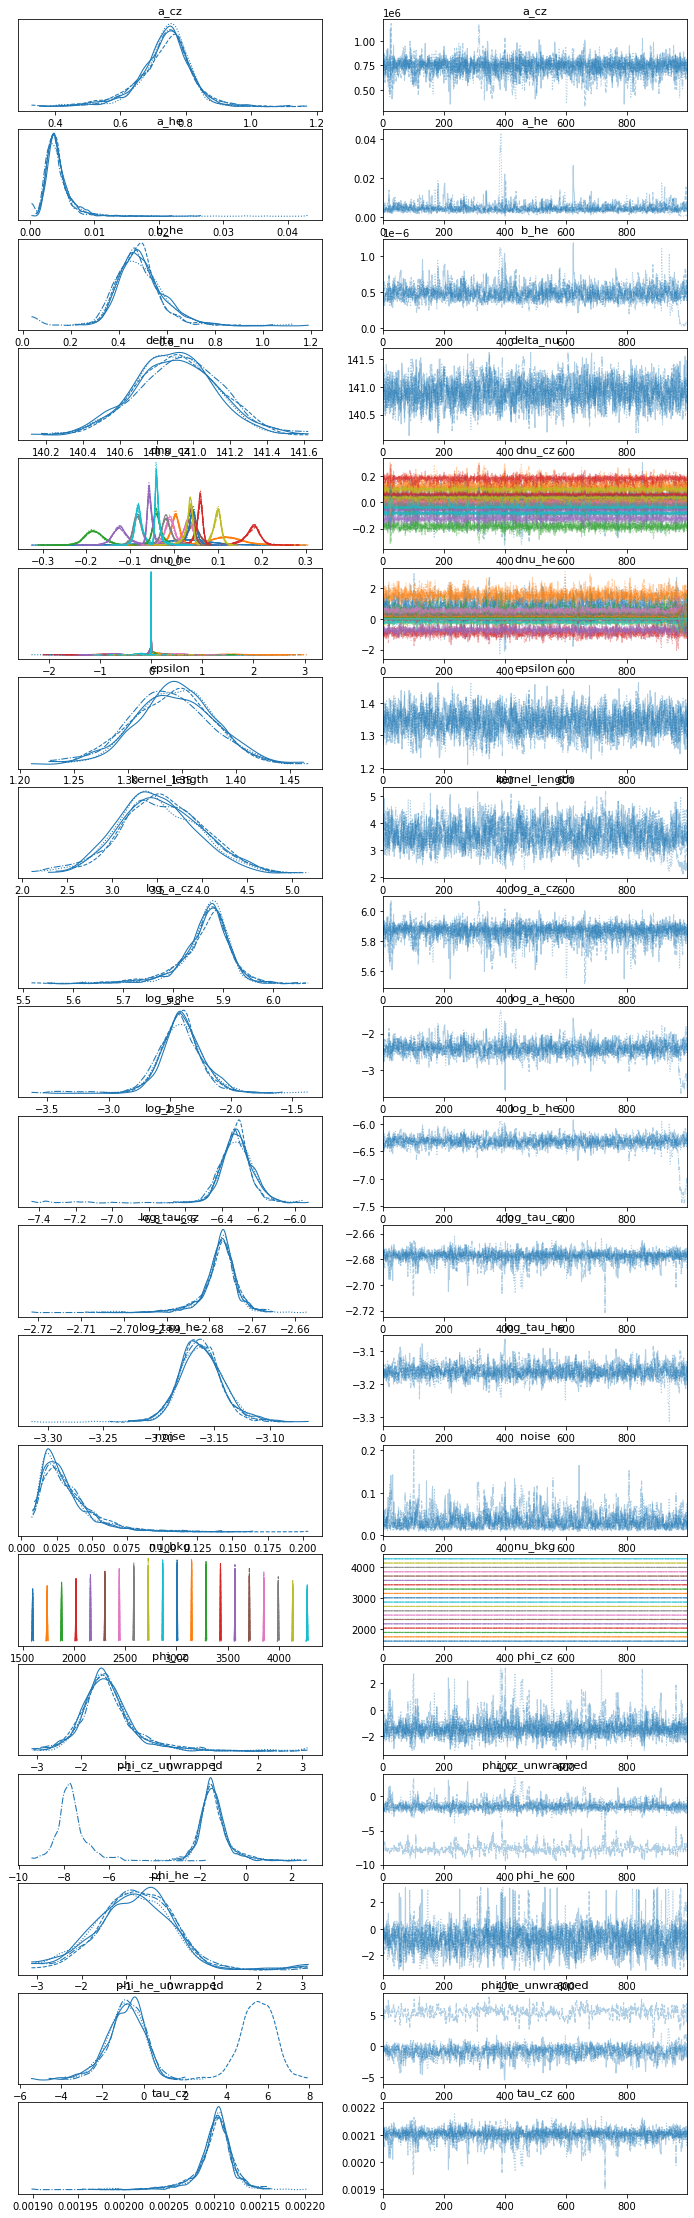

In [18]:
az.plot_trace(data);

In [19]:
summary = infer.get_summary()
summary

<xarray.Dataset>
Dimensions:           (metric: 12, n: 20)
Coordinates:
  * n                 (n) int64 10 11 12 13 14 15 16 17 ... 23 24 25 26 27 28 29
  * metric            (metric) <U9 'mean' 'sd' 'hdi_3%' ... '16th' '50th' '84th'
Data variables: (12/21)
    a_cz              (metric) float64 7.359e+05 8.224e+04 ... 8.043e+05
    a_he              (metric) float64 0.004289 0.002229 ... 0.003885 0.005639
    b_he              (metric) float64 4.871e-07 1.015e-07 ... 5.715e-07
    delta_nu          (metric) float64 140.9 0.2223 140.5 ... 140.7 140.9 141.1
    dnu_cz            (metric, n) float64 0.0173 0.1174 ... 0.04155 -0.03164
    dnu_he            (metric, n) float64 0.706 1.526 ... 0.001022 -0.0002774
    ...                ...
    phi_cz            (metric) float64 -1.447 0.5924 -2.54 ... -1.473 -0.9261
    phi_cz_unwrapped  (metric) float64 -2.657 2.587 -8.398 ... -1.618 -1.044
    phi_he            (metric) float64 -0.8128 0.856 -2.501 ... -0.7776 0.02382
    phi_he_unwrapped  (metric) float64 0.3974 2.699 -2.502 ... -0.5467 4.862
    tau_cz            (metric) float64 0.002101 2.026e-05 ... 0.002103 0.002116
    tau_he            (metric) float64 0.0006892 3.126e-05 ... 0.0007172

In [46]:
dim_vars = {}
for k in summary.data_vars.keys():
    dims = summary[k].dims
    if dims not in dim_vars.keys():
        dim_vars[dims] = []
    dim_vars[dims].append(k)

In [64]:
dfs = []
for dim in dim_vars.values():
    dfs.append(summary[dim].to_dataframe())

In [65]:
dfs[0]

,a_cz,a_he,b_he,delta_nu,epsilon,kernel_length,log_a_cz,log_a_he,log_b_he,log_tau_cz,log_tau_he,noise,phi_cz,phi_cz_unwrapped,phi_he,phi_he_unwrapped,tau_cz,tau_he
metric,,,,,,,,,,,,,,,,,,
mean,735869.466775,0.004289,4.871322e-07,140.906594,1.342103,3.541722,5.863848,-2.407529,-6.323243,-2.677640,-3.162129,0.032130,-1.447347,-2.657112,-0.812757,0.397366,2.100778e-03,6.891537e-04
sd,82244.431570,0.002229,1.015179e-07,0.222317,0.036518,0.451766,0.051993,0.184691,0.106932,0.004221,0.019648,0.018414,0.592366,2.587022,0.855963,2.699499,2.026056e-05,3.126185e-05
hdi_3%,577962.335534,0.001459,3.156238e-07,140.470910,1.275564,2.743783,5.761900,-2.731883,-6.470637,-2.685888,-3.196783,0.009153,-2.539912,-8.398068,-2.501236,-2.501560,2.061162e-03,6.322429e-04
hdi_97%,893925.631580,0.007710,6.676044e-07,141.302522,1.413740,4.445772,5.951301,-2.071541,-6.156569,-2.670417,-3.123893,0.065018,-0.151897,-0.312774,0.743100,6.381589,2.135909e-03,7.478796e-04
mcse_mean,1968.537945,0.000070,4.015388e-09,0.005898,0.000974,0.015870,0.001316,0.007264,0.006723,0.000110,0.000543,0.000664,0.011467,1.117584,0.028990,1.140242,5.270965e-07,8.680999e-07
mcse_sd,1392.199186,0.000053,2.840605e-09,0.004172,0.000689,0.011226,0.000931,0.005827,0.005004,0.000078,0.000384,0.000470,0.012450,0.848254,0.018271,0.852400,3.727871e-07,6.167271e-07
ess_bulk,2055.073812,993.091065,7.933870e+02,1419.358847,1403.956814,801.973349,2055.073812,993.091065,793.386958,1818.805022,1347.211242,810.894535,1739.983404,10.209657,1468.883928,10.014125,1.818805e+03,1.347211e+03
ess_tail,1377.784965,883.833137,6.435586e+02,2291.394338,2325.292124,578.587279,1377.784965,883.833137,643.558593,1440.749530,1730.722412,1398.451162,1412.572436,28.774792,1858.192090,28.152786,1.440750e+03,1.730722e+03
r_hat,1.002919,1.010724,1.012297e+00,1.004400,1.004502,1.006078,1.002809,1.010724,1.012297,1.003451,1.002441,1.005474,1.001954,1.438740,1.003035,1.442994,1.003453e+00,1.002522e+00


In [79]:
precision = np.log10(dfs[0].loc['mcse_mean']).astype(int)  # Typical precision from Markov-chain standard error

We report to MCSE precision

In [81]:
dfs[0].loc[['mean', 'sd', '16th', '50th', '84th']].round(-precision)

,a_cz,a_he,b_he,delta_nu,epsilon,kernel_length,log_a_cz,log_a_he,log_b_he,log_tau_cz,log_tau_he,noise,phi_cz,phi_cz_unwrapped,phi_he,phi_he_unwrapped,tau_cz,tau_he
metric,,,,,,,,,,,,,,,,,,
mean,736000.0,0.0043,4.900000e-07,140.91,1.342,3.5,5.86,-2.41,-6.32,-2.678,-3.162,0.032,-1.4,-3.0,-0.8,0.0,0.002101,0.000689
sd,82000.0,0.0022,1.000000e-07,0.22,0.037,0.5,0.05,0.18,0.11,0.004,0.020,0.018,0.6,3.0,0.9,3.0,0.000020,0.000031
16th,667000.0,0.0027,4.000000e-07,140.69,1.306,3.1,5.82,-2.56,-6.40,-2.681,-3.180,0.017,-1.9,-7.0,-1.6,-2.0,0.002087,0.000661
50th,745000.0,0.0039,4.800000e-07,140.91,1.343,3.5,5.87,-2.41,-6.32,-2.677,-3.163,0.027,-1.5,-2.0,-0.8,-1.0,0.002103,0.000687
84th,804000.0,0.0056,5.700000e-07,141.13,1.379,4.0,5.91,-2.25,-6.24,-2.674,-3.144,0.047,-0.9,-1.0,0.0,5.0,0.002116,0.000717


In [66]:
dfs[1]

dnu_cz    dnu_he       nu_bkg
metric n                                  
mean   10  0.017298  0.705990  1598.169445
       11  0.117439  1.526454  1739.076039
       12 -0.181697  0.358771  1879.982634
       13  0.176407 -0.868062  2020.889228
       14 -0.120325 -0.716914  2161.795823
...             ...       ...          ...
84th   25  0.045009  0.005872  3713.847029
       26  0.001961  0.022210  3854.853927
       27 -0.003844  0.013778  3995.911331
       28  0.041548  0.001022  4136.986622
       29 -0.031644 -0.000277  4278.042647

[240 rows x 3 columns]

In [24]:
def get_circ_var_names(self) -> list:
    """[summary]

    Returns:
        Circular variable names in the model
    """
    var_names = []
    trace = self.get_trace(self._model_args, self._model_kwargs)
    for key, value in trace.items():
        if value['type'] == 'sample':
            if value['fn'].support is constraints.circular:
                var_names.append(value['name'])
    return var_names

get_circ_var_names(infer)

['phi_he', 'phi_cz']

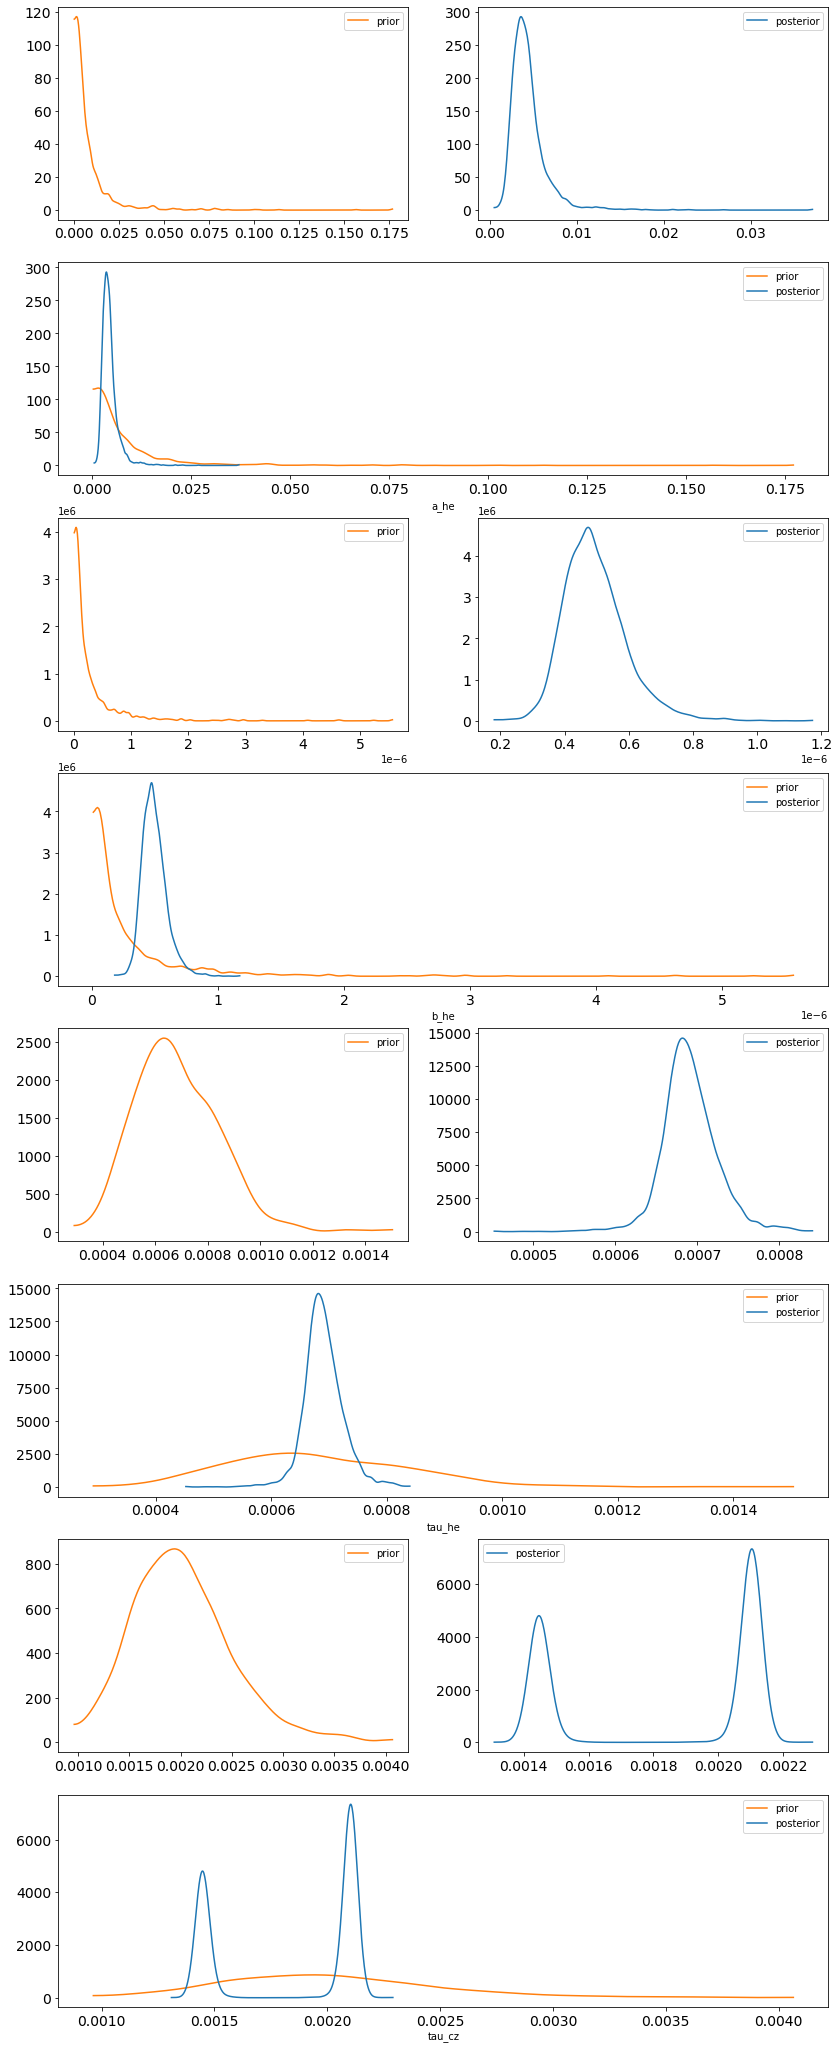

In [42]:
az.plot_dist_comparison(data, var_names=['a_he', 'b_he', 'tau_he', 'tau_cz']);

In [40]:
az.summary(data, round_to='none')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_cz,7.355286e+05,8.090542e+04,5.565821e+05,8.710715e+05,1.877889e+03,1.328076e+03,2223.366380,1613.298223,1.000765
a_he,4.392508e-03,2.219730e-03,1.697947e-03,8.009725e-03,5.984693e-05,4.232714e-05,1353.351727,1635.342314,1.003400
b_he,4.942649e-07,9.781364e-08,3.281480e-07,6.830504e-07,2.724224e-09,1.926753e-09,1255.020218,1915.197344,1.004484
delta_nu,1.409053e+02,2.224248e-01,1.404739e+02,1.413177e+02,5.829525e-03,4.123317e-03,1451.660464,1953.562089,1.001744
dnu_cz[10.0],1.695959e-02,6.867613e-02,-1.183231e-01,1.425607e-01,1.485756e-03,1.074072e-03,2299.030012,2124.167391,1.000351
...,...,...,...,...,...,...,...,...,...
phi_cz_unwrapped,5.133826e+00,6.260761e+00,-2.087794e+00,1.554060e+01,2.770606e+00,2.083378e+00,6.092641,25.644439,2.809700
phi_he,-7.880547e-01,9.650954e-01,-2.882321e+00,5.695716e-01,2.305993e-02,1.843612e-02,1682.494074,1635.936060,1.002477
phi_he_unwrapped,-9.124618e-01,9.250992e-01,-2.692211e+00,7.618561e-01,2.511534e-02,1.821065e-02,1395.109195,1695.497751,1.001978
tau_cz,1.839901e-03,3.203232e-04,1.424812e-03,2.127726e-03,1.422904e-04,1.070502e-04,7.923449,91.265405,1.682381


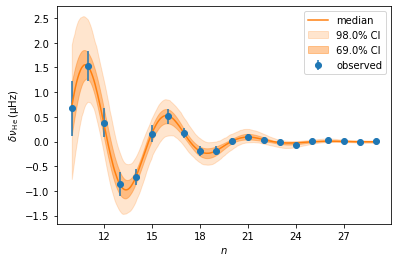

In [35]:
model.plot_glitch(data, quantiles=[.01, .16, .85, .99]);

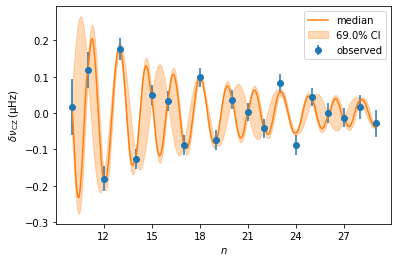

In [19]:
model.plot_glitch(data, kind='CZ', quantiles=[.16, .85]);

In [41]:
nu_max

(3246.741439401651, 162.33707197008255)

Text(0, 0.5, 'nu (muHz)')

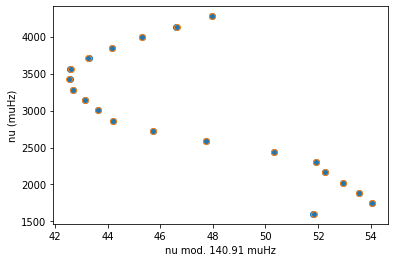

In [23]:
dim = ('chain', 'draw')

delta_nu = data.posterior['delta_nu'].mean(dim=dim)
nu_mean = data.posterior_predictive['nu'].mean(dim=dim)
nu_std = data.posterior_predictive['nu'].std(dim=dim)

nu_obs = data.observed_data['nu_obs']

plt.plot(nu_obs%delta_nu, nu_obs, marker='o', linestyle='none');
plt.errorbar(nu_mean%delta_nu, nu_mean, xerr=nu_std, marker='o', linestyle='none', markerfacecolor='none')

plt.xlabel(f'nu mod. {delta_nu.values:.2f} muHz')
plt.ylabel('nu (muHz)')

In [47]:
hdl = numpyro.handlers
self = infer
rng_key, self._rng_key = random.split(self._rng_key)
model = hdl.trace(
    hdl.seed(
        self.model, rng_key
    )
)
trace = model.get_trace(*self._model_args, **self._model_kwargs)

In [58]:
from numpyro.distributions.constraints import circular
distrib = trace['phi_he']['fn']
distrib.support is circular

True

In [48]:
from numpyro.distributions.constraints import circular

for key, value in trace.items():
    if value['type'] == 'sample':
        if value['fn'].support is circular:

OrderedDict([('delta_nu',
              {'type': 'sample',
               'name': 'delta_nu',
               'fn': <numpyro.distributions.continuous.Normal at 0x13474f6a0>,
               'args': (),
               'kwargs': {'rng_key': array([2471512433, 1182377652], dtype=uint32),
                'sample_shape': ()},
               'value': DeviceArray(140.04183452, dtype=float64),
               'scale': None,
               'is_observed': False,
               'intermediates': [],
               'cond_indep_stack': [],
               'infer': {}}),
             ('epsilon',
              {'type': 'sample',
               'name': 'epsilon',
               'fn': <numpyro.distributions.continuous.Gamma at 0x13474f730>,
               'args': (),
               'kwargs': {'rng_key': array([984546986, 143607929], dtype=uint32),
                'sample_shape': ()},
               'value': DeviceArray(0.7437584, dtype=float64),
               'scale': None,
               'is_observed': Fa

In [44]:
stat_funcs = {
    "16th": lambda x: np.quantile(x, .16),
    "50th": np.median,
    "84th": lambda x: np.quantile(x, .84),
}
summary = az.summary(data, group='posterior', fmt='xarray', circ_var_names=['phi_he', 'phi_cz'], stat_funcs=stat_funcs)

In [68]:
summary.to_dataframe()

a_cz      a_he          b_he    delta_nu    dnu_cz  \
metric n                                                                   
mean   10.0  735528.616334  0.004393  4.942649e-07  140.905262  0.016960   
       11.0  735528.616334  0.004393  4.942649e-07  140.905262  0.117601   
       12.0  735528.616334  0.004393  4.942649e-07  140.905262 -0.181754   
       13.0  735528.616334  0.004393  4.942649e-07  140.905262  0.176444   
       14.0  735528.616334  0.004393  4.942649e-07  140.905262 -0.120406   
...                    ...       ...           ...         ...       ...   
84th   25.0  800855.021165  0.005740  5.801688e-07  141.129964  0.045257   
       26.0  800855.021165  0.005740  5.801688e-07  141.129964  0.002115   
       27.0  800855.021165  0.005740  5.801688e-07  141.129964 -0.003304   
       28.0  800855.021165  0.005740  5.801688e-07  141.129964  0.041638   
       29.0  800855.021165  0.005740  5.801688e-07  141.129964 -0.031790   

               dnu_he   epsilon  kernel_length  log_a_cz  log_a_he  ...  \
metric n                                                            ...   
mean   10.0  0.678507  1.342460       3.518176  5.863703 -2.396192  ...   
       11.0  1.536318  1.342460       3.518176  5.863703 -2.396192  ...   
       12.0  0.383572  1.342460       3.518176  5.863703 -2.396192  ...   
       13.0 -0.853663  1.342460       3.518176  5.863703 -2.396192  ...   
       14.0 -0.718929  1.342460       3.518176  5.863703 -2.396192  ...   
...               ...       ...            ...       ...       ...  ...   
84th   25.0  0.005816  1.378129       3.961089  5.903554 -2.241076  ...   
       26.0  0.021482  1.378129       3.961089  5.903554 -2.241076  ...   
       27.0  0.013296  1.378129       3.961089  5.903554 -2.241076  ...   
       28.0  0.000876  1.378129       3.961089  5.903554 -2.241076  ...   
       29.0 -0.000194  1.378129       3.961089  5.903554 -2.241076  ...   

             log_tau_cz  log_tau_he     noise       nu_bkg    phi_cz  \
metric n                                                               
mean   10.0   -2.742231   -3.161347  0.031564  1598.204774 -2.142674   
       11.0   -2.742231   -3.161347  0.031564  1739.110035 -2.142674   
       12.0   -2.742231   -3.161347  0.031564  1880.015297 -2.142674   
       13.0   -2.742231   -3.161347  0.031564  2020.920559 -2.142674   
       14.0   -2.742231   -3.161347  0.031564  2161.825820 -2.142674   
...                 ...         ...       ...          ...       ...   
84th   25.0   -2.675454   -3.142545  0.045718  3713.849451  2.464487   
       26.0   -2.675454   -3.142545  0.045718  3854.906657  2.464487   
       27.0   -2.675454   -3.142545  0.045718  3995.954224  2.464487   
       28.0   -2.675454   -3.142545  0.045718  4137.022396  2.464487   
       29.0   -2.675454   -3.142545  0.045718  4278.091605  2.464487   

             phi_cz_unwrapped    phi_he  phi_he_unwrapped    tau_cz    tau_he  
metric n                                                                       
mean   10.0          5.133826 -0.860370         -0.912462  0.001840  0.000691  
       11.0          5.133826 -0.860370         -0.912462  0.001840  0.000691  
       12.0          5.133826 -0.860370         -0.912462  0.001840  0.000691  
       13.0          5.133826 -0.860370         -0.912462  0.001840  0.000691  
       14.0          5.133826 -0.860370         -0.912462  0.001840  0.000691  
...                       ...       ...               ...       ...       ...  
84th   25.0         14.550737 -0.020235         -0.080807  0.002111  0.000720  
       26.0         14.550737 -0.020235         -0.080807  0.002111  0.000720  
       27.0         14.550737 -0.020235         -0.080807  0.002111  0.000720  
       28.0         14.550737 -0.020235         -0.080807  0.002111  0.000720  
       29.0         14.550737 -0.020235         -0.080807  0.002111  0.000720  

[240 rows x 21 columns]

In [66]:
summary

<xarray.Dataset>
Dimensions:           (metric: 12, n: 20)
Coordinates:
  * n                 (n) float64 10.0 11.0 12.0 13.0 ... 26.0 27.0 28.0 29.0
  * metric            (metric) <U9 'mean' 'sd' 'hdi_3%' ... '16th' '50th' '84th'
Data variables: (12/21)
    a_cz              (metric) float64 7.355e+05 8.091e+04 ... 8.009e+05
    a_he              (metric) float64 0.004393 0.00222 ... 0.00397 0.00574
    b_he              (metric) float64 4.943e-07 9.781e-08 ... 5.802e-07
    delta_nu          (metric) float64 140.9 0.2224 140.5 ... 140.7 140.9 141.1
    dnu_cz            (metric, n) float64 0.01696 0.1176 ... 0.04164 -0.03179
    dnu_he            (metric, n) float64 0.6785 1.536 ... 0.0008763 -0.0001942
    ...                ...
    phi_cz            (metric) float64 -2.143 1.47 1.475 ... -1.816 -1.069 2.464
    phi_cz_unwrapped  (metric) float64 5.134 6.261 -2.088 ... -1.584 4.77 14.55
    phi_he            (metric) float64 -0.8604 0.8872 ... -0.7942 -0.02023
    phi_he_unwrapped  (metric) float64 -0.9125 0.9251 ... -0.8407 -0.08081
    tau_cz            (metric) float64 0.00184 0.0003203 ... 0.002087 0.002111
    tau_he            (metric) float64 0.0006905 3.388e-05 ... 0.0007202